# Decision Tree Classifier Project

The goal of this project is to classify patients having diabetes or no, based on their diagnostics.

###  Importing Libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

### Loading the dataset

In [2]:
# Loading the dataset
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv')

Data Dictionary:

**Pregnancies:** Number of times pregnant

**Glucose:** Plasma glucose concentration a 2 hours in an oral glucose tolerance test

**BloodPressure:** Diastolic blood pressure (mm Hg)

**SkinThickness:** Triceps skin fold thickness (mm)

**Insulin:** 2-Hour serum insulin (mu U/ml)

**BMI:** Body mass index (weight in kg/(height in m)^2)

**DiabetesPedigreeFunction:** Diabetes pedigree function

**Age:** Age (years)

**Outcome:** Class variable (0 or 1), Class Distribution: (class value 1 is interpreted as "tested positive for diabetes")

Source:

(a) Original owners: National Institute of Diabetes and Digestive and Kidney Diseases (b) Donor of database: Vincent Sigillito (vgs@aplcen.apl.jhu.edu) Research Center, RMI Group Leader Applied Physics Laboratory The Johns Hopkins University

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df_raw.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Data Exploration


### Null or duplicated values check

In [5]:
print(df_raw.isnull().sum().sort_values(ascending=False))

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [6]:
df_raw.duplicated().any()

False

* There is no duplicated data or null values present in the dataset.

### Descriptive Statistics

In [7]:
round(df_raw.describe())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0
mean,4.0,121.0,69.0,21.0,80.0,32.0,0.0,33.0,0.0
std,3.0,32.0,19.0,16.0,115.0,8.0,0.0,12.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0
25%,1.0,99.0,62.0,0.0,0.0,27.0,0.0,24.0,0.0
50%,3.0,117.0,72.0,23.0,30.0,32.0,0.0,29.0,0.0
75%,6.0,140.0,80.0,32.0,127.0,37.0,1.0,41.0,1.0
max,17.0,199.0,122.0,99.0,846.0,67.0,2.0,81.0,1.0


## Data visualization

### Relation between variables

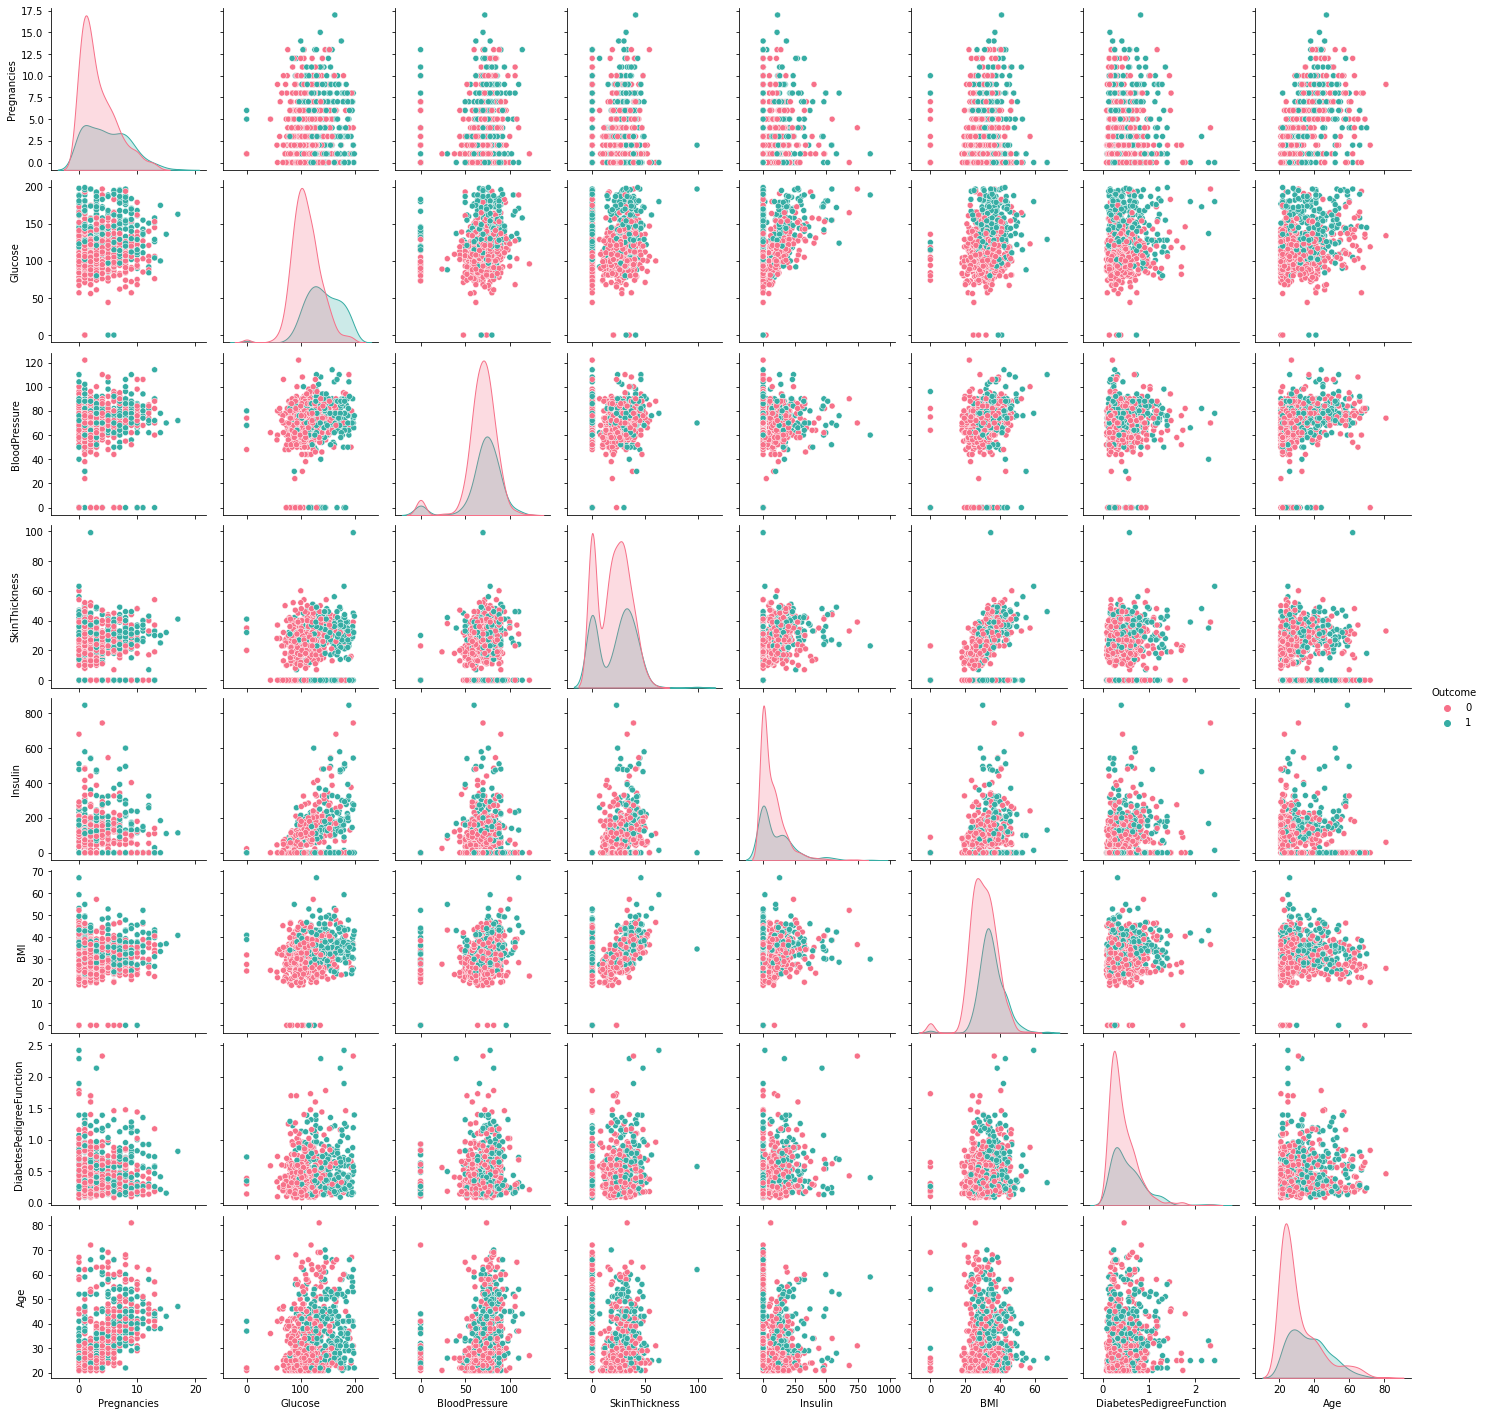

In [8]:
sns.pairplot(df_raw, hue='Outcome', palette='husl')

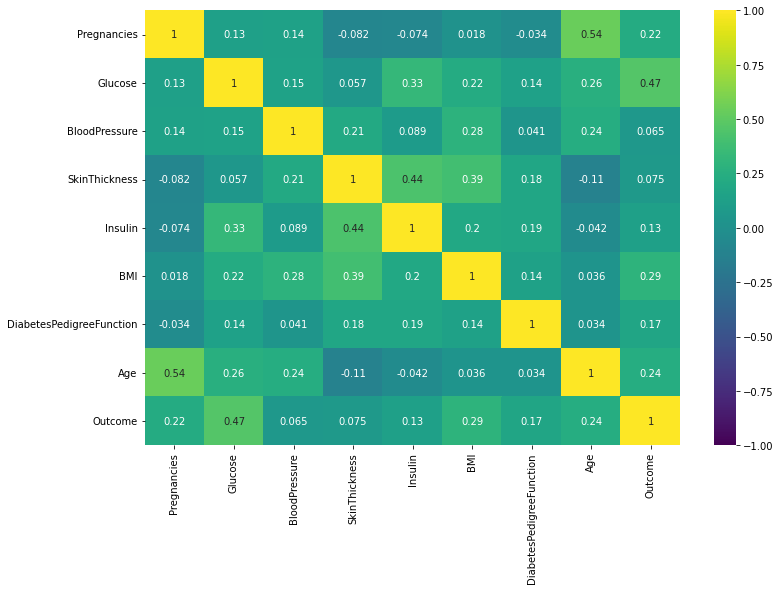

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_raw.corr(), annot=True,cmap='viridis', vmax=1, vmin=-1, center=0)

From this plots is observable that, a higher glucose in pregnancies or in every age is related to a positive outcome. As for pregnancies, more times pregnant increases the posbility of a positive outcome. As for skin thickness with high blood pressure increases the posbility of a positive outcome. As for BMI, with a high glucose increases the posbility of a positive outcome. An last, for age, more age show more postives outcome.

Also, it is observable a strong postive relation between age and pregnancies, and a strogn positive relation between outcome and glucose as expected.

### Outliers analysis

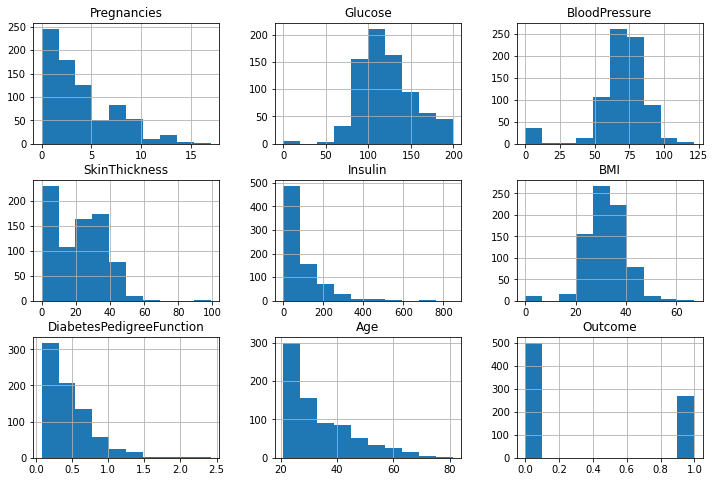

In [10]:
df_raw.hist(figsize=(12,8))
plt.show()

In [11]:
variables = df_raw.columns
for v in variables: 
    plt.figure(figsize=(5,5))
    fig = px.box(df_raw, y=[v] )
    fig.show()

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

We observe several outliers in the variables except in outcome, in order to obtain more information about them we use IQR method to know the boundaries. After that, we count how many register are above the upper bound and choose if we remove them or if we keep them.

In [12]:
# Using the IQR method function
def iqr_calc(col_name):
  stat = round(df_raw[f'{col_name}'].describe(), 2)
  print(stat)
  IQR = stat['75%']-stat['25%']
  upper = stat['75%'] + 1.5*IQR
  lower = stat['25%'] - 1.5*IQR
  rows_out_up= df_raw[df_raw[f'{col_name}'] > upper].count()
  rows_out_l= df_raw[df_raw[f'{col_name}'] < lower].count()
  return f'In the {col_name} case the upper & lower for bounds for suspected outliers are {upper} and {lower}. Total of row off upper bound \n{rows_out_up}\n Total of row off lower bound \n{rows_out_l}\n'

In [13]:
variables = df_raw.columns
for v in variables: 
  print(iqr_calc(v))
  print("\n")

count    768.00
mean       3.85
std        3.37
min        0.00
25%        1.00
50%        3.00
75%        6.00
max       17.00
Name: Pregnancies, dtype: float64
In the Pregnancies case the upper & lower for bounds for suspected outliers are 13.5 and -6.5. Total of row off upper bound 
Pregnancies                 4
Glucose                     4
BloodPressure               4
SkinThickness               4
Insulin                     4
BMI                         4
DiabetesPedigreeFunction    4
Age                         4
Outcome                     4
dtype: int64
 Total of row off lower bound 
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64



count    768.00
mean     120.89
std       31.97
min        0.00
25%       99.00
50%      117.00
75%      140.25
m

In [14]:
# Create a copy of the original dataset
df = df_raw.copy()

In [15]:
# Remove the outliers
df=df.drop(df[df['Pregnancies'] > 13.5].index)
df=df.drop(df[df['Glucose'] < 37.125].index)
df=df.drop(df[(df['BloodPressure'] > 107.0) | (df['BloodPressure'] < 35.0)].index)
df=df.drop(df[df['SkinThickness'] > 80.0].index)
df=df.drop(df[df['Insulin'] > 318.125].index)
df=df.drop(df[(df['BMI'] > 50.55) | (df['BMI'] < 13.35)].index)
df=df.drop(df[df['DiabetesPedigreeFunction'] > 1.2149999999999999].index)
df=df.drop(df[df['Age'] > 66.5].index)

## Balance in the target variable

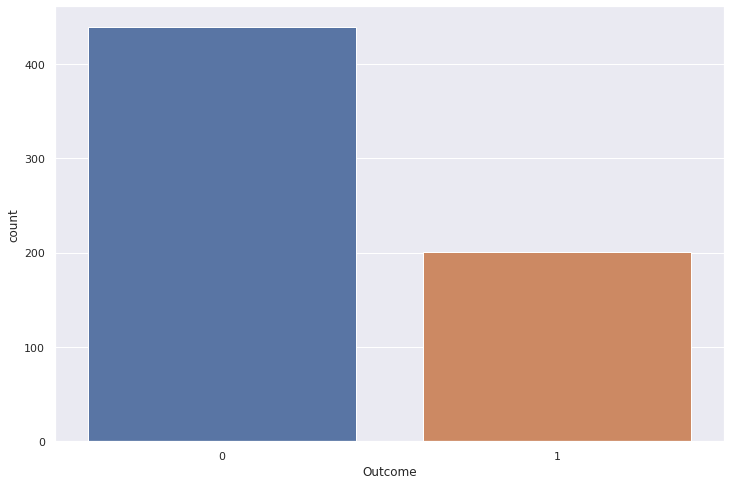

In [16]:
sns.set(rc = {'figure.figsize':(12,8)})
data = df.sort_values(by=['Outcome'])
sns.countplot(x=data['Outcome'], data=data, order=df['Outcome'].value_counts().index)
plt.show()

## Construction of the model and results

In [17]:
X_inb = df.drop('Outcome',axis=1)
y_inb = df['Outcome']

* Balancing the target variable using random Over-Sampling to add more copies to the minority class.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



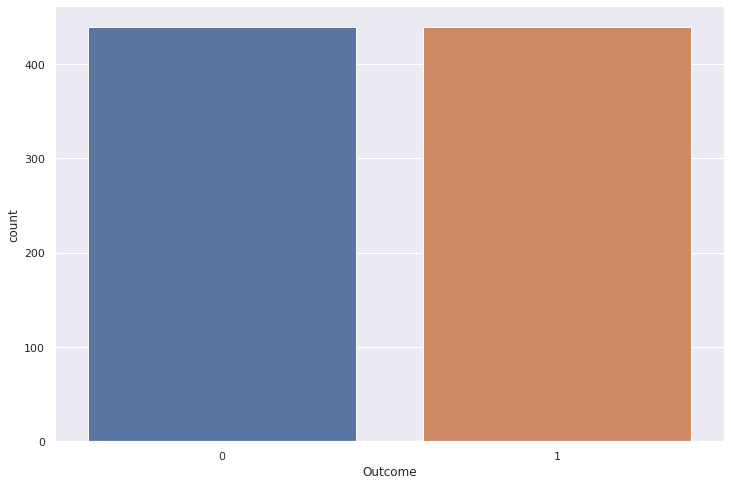

In [18]:
# We use random Over-Sampling to add more copies to the minority class
os =  RandomOverSampler()
X,y = os.fit_resample(X_inb,y_inb)
sns.countplot(y)

In [19]:
# Spliting the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=40)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(702, 8) (176, 8) (702,) (176,)


### The model

In [20]:
pipeline = make_pipeline(StandardScaler(), DecisionTreeClassifier()) 
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

### The results

In [21]:
print("Score with in train dataset:", round(pipeline.score(X_train, y_train), 4))
print("Score with in test dataset:", round(pipeline.score(X_test, y_test), 4)) 

Score with in train dataset: 1.0
Score with in test dataset: 0.8466


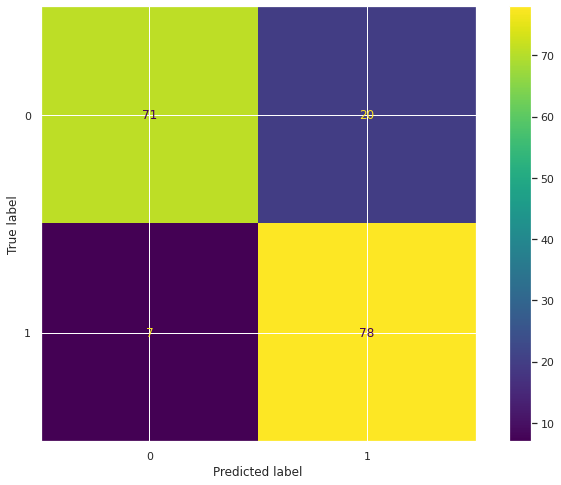

In [22]:
y_pred=pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=pipeline.classes_)
disp.plot()

plt.show()

In [23]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84        91
           1       0.80      0.92      0.85        85

    accuracy                           0.85       176
   macro avg       0.85      0.85      0.85       176
weighted avg       0.86      0.85      0.85       176



### Hypertune

In [24]:
#Using Grid Search to get best hyperparameters
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
params = {
    'max_depth': [2, 3, 5, 10, 20, 50],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'splitter': ['best', 'random'],
    'criterion': ["gini", "entropy"]
}
opt_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=cv, scoring='accuracy',error_score=0)
opt_dt.fit(X_train,y_train)
# Summarize results
print("Best: %f using %s" % (opt_dt.best_score_, opt_dt.best_params_))


Best: 0.779691 using {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5, 'splitter': 'best'}


In [25]:
opt_pipeline = make_pipeline(StandardScaler(), DecisionTreeClassifier(criterion= 'entropy', max_depth= 20, min_samples_leaf= 5)) 
opt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=20,
                                        min_samples_leaf=5))])

In [26]:
print("Score with in train dataset:", round(opt_pipeline.score(X_train, y_train), 4))
print("Score with in test dataset:", round(opt_pipeline.score(X_test, y_test), 4)) 

Score with in train dataset: 0.9217
Score with in test dataset: 0.7898


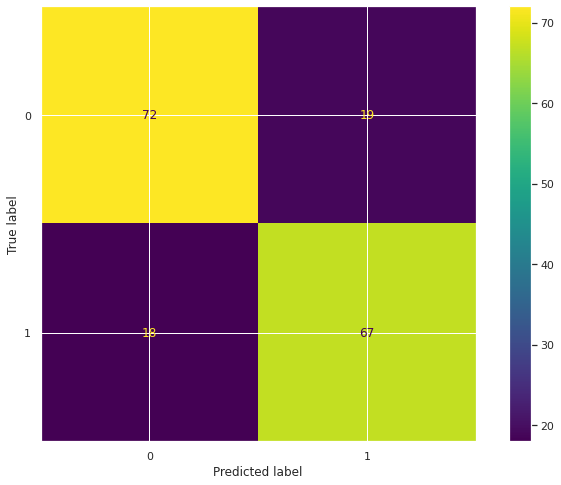

In [27]:
y_pred=opt_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=opt_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=opt_pipeline.classes_)
disp.plot()

plt.show()

In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80        91
           1       0.78      0.79      0.78        85

    accuracy                           0.79       176
   macro avg       0.79      0.79      0.79       176
weighted avg       0.79      0.79      0.79       176

